<center><span style='color:darkblue'><h1>SMS Spam Classifier</style></h1></center>
<br>
<center><h2>Steven Mielke, Ph.D.</h2></center>
<center><h3>May 23, 2020</h3></center>
<br>

## Summary

This project develops a support vector machine (SVM) model for short-message-service (SMS) spam detection (two-class classification). The model is trained and tested using 5,574 examples of real text messages, labeled as 'spam' or 'ham' (not spam).<sup>1</sup> For the chosen 75-25 split of the data into a training set with 4,180 examples and a test set with 1,394 examples, the model classifies training-set messages with an accuracy of 0.9921, and test-set messages with an accuracy of 0.9864. Predictions on the test set yield an F<sub>1</sub> score of 0.9861, with precision 0.9865 and recall 0.9864. Of the 1,208 ham messages in the test set, only one is incorrectly identified as spam.

|              | Training Set | Test Set |
|--------------|--------------|----------|
|   Accuracy   |     0.9921   |   0.9864 |
| F<sub>1</sub>|       -      |   0.9861 |
|   *P*        |       -      |   0.9865 |
|   *R*        |       -      |   0.9864 |

<br>

1. http://www.dt.fee.unicamp.br/~tiago/smsspamcollection/



<br>
<center><h2>Table of Contents</h2></center>

<center>
<span style='font-size:1.5em;'>
    <strong><a href='#Data'>1. Data & Preprocessing</a></strong><br>
    <a href='#Import'>1.1. Data import</a><br> 
    <a href='#Separate'>1.2. Data separation</a><br>
    <a href='#Preprocess'>1.3. Data preprocessing</a><br>
    <a href='#Dictionary'>1.4. Vocabulary list and data indexing</a><br>
<strong><a href='#Features'>2. Feature Extraction</a><strong><br>
    <strong><a href='#Model'>3. Modeling & Analysis</a></strong><br>
    <strong><a href='#Results'>4. Results & Conclusion</a></strong><br>
</span>
</center>

<a name='Data'></a>
## 1. Data & Preprocessing

The data file 'SMSSpamCollection.txt' was downloaded as plain text from Ref. 1 (see Summary). Each line of the file (5,574 total) contains the string label 'spam' or 'ham', followed by the raw text message to which the label refers. The preprocessing procedure, which includes normalization of the raw data, is described in <a href='#Preprocess'>**Section 1.3**</a>. In <a href='#Dictionary'>**Section 1.4**</a>, an indexed vocabulary list of the most frequently occurring words is generated from the preprocessed dataset, then referenced to replace the words in each preprocessed example with the corresponding numerical indices, which facilitates feature extraction (<a href='#Features'>**Section 2**</a>). 

<a name='Import'></a>
### 1.1. Read data file \[1\] to dataframe 'df1' with columns 'Class', 'Text'

In [1]:
import pandas as pd

In [2]:
path = '/resources/Spam-SVM/SMSSpamCollection.txt'
df1 = pd.read_table(path, names=('Class', 'Text'))
df1

,Class,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5569,spam,This is the 2nd time we have tried 2 contact u...
5570,ham,Will ü b going to esplanade fr home?
5571,ham,"Pity, * was in mood for that. So...any other s..."
5572,ham,The guy did some bitching but I acted like i'd...


#### Define *m* = 5574 as total number of examples

In [5]:
m = df1.shape[0]
print('m = %s\n' % m)
print('Number of rows in \'df1\' (total number of examples):  %s' % m)

m = 5574

Number of rows in 'df1' (total number of examples):  5574


<a name='Separate'></a>
### 1.2. Write spam- and ham-labeled messages to separate files ('spam.txt', 'ham.txt') for organizational purposes 

#### Write 'spam.txt'

In [8]:
spam_txt = open('spam.txt', 'w')
for i in range(0,m):
    if (df1.iloc[i,0] == 'spam'):
        spam_txt.write(df1.iloc[i,1])
        spam_txt.write('\n')
spam_txt.close()        

#### Print first five lines of 'spam.txt'; total lines (examples of spam) = 747

In [8]:
tmp = open('spam.txt', 'r')
contents = tmp.readlines()
ctr = 0
for i in contents:
    if (ctr < 5):
        print(i, end="")
    ctr += 1

ctr = 0
for i in contents:
    ctr += 1
print('\nNumber of rows in \'spam.txt\' (total number of spam [y = 1] examples):  %s' % ctr)

Free entry in 2 a wkly comp to win FA Cup final tkts 21st May 2005. Text FA to 87121 to receive entry question(std txt rate)T&C's apply 08452810075over18's
FreeMsg Hey there darling it's been 3 week's now and no word back! I'd like some fun you up for it still? Tb ok! XxX std chgs to send, £1.50 to rcv
WINNER!! As a valued network customer you have been selected to receivea £900 prize reward! To claim call 09061701461. Claim code KL341. Valid 12 hours only.
Had your mobile 11 months or more? U R entitled to Update to the latest colour mobiles with camera for Free! Call The Mobile Update Co FREE on 08002986030
SIX chances to win CASH! From 100 to 20,000 pounds txt> CSH11 and send to 87575. Cost 150p/day, 6days, 16+ TsandCs apply Reply HL 4 info

Number of rows in 'spam.txt' (total number of spam [y = 1] examples):  747


#### Write 'ham.txt' 

In [4]:
spam_txt = open('ham.txt', 'w')
for i in range(0,m):
    if (df1.iloc[i,0] == 'ham'):
        spam_txt.write(df1.iloc[i,1])
        spam_txt.write('\n')
spam_txt.close()        

#### Print first five lines of 'ham.txt'; total lines (examples of ham) = 4,827

In [9]:
tmp = open('ham.txt', 'r')
contents = tmp.readlines()
ctr = 0
for i in contents:
    if (ctr < 5):
        print(i, end="")
    ctr += 1
    
ctr = 0
for i in contents:
    ctr += 1
print('\nNumber of rows in \'ham.txt\' (total number of ham [y = 0] examples):  %s' % ctr)

Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...
Ok lar... Joking wif u oni...
U dun say so early hor... U c already then say...
Nah I don't think he goes to usf, he lives around here though
Even my brother is not like to speak with me. They treat me like aids patent.

Number of rows in 'ham.txt' (total number of ham [y = 0] examples):  4827


<a name='Preprocess'></a>
### 1.3. Preprocess 'spam.txt', 'ham.txt'
Preprocessing was performed on MATLAB Online, using a modified version of the script 'processEmail.m' from the programming exercises (/ex6) in Week 7 of Andrew Ng's online course, *Machine Learning* (Coursera / Stanford).<sup>2</sup> The script calls additional functions, such as a stemmer ('porterStemmer.m'), to perform the following preprocessing and normalization procedures on the raw data:

* Lower-casing: The entire dataset is converted to lower case, so that capitalization is ignored (e.g., IndIcaTE is treated the same as indicate).
* Stripping HTML: All HTML tags are removed, so that only the corresponding content remains.
* Normalizing URLs: All URLs are replaced with the text 'httpaddr'.
* Normalizing Email Addresses: All email addresses are replaced with the text 'emailaddr'.
* Normalizing Numbers: All numbers are replaced with the text 'number'.
* Normalizing Dollars: All dollar signs ($) are replaced with the text 'dollar'.
* Word Stemming: Words are reduced to their stemmed form. For example, 'discount', 'discounts', 'discounted', and 'discounting' are all replaced with 'discount'. Sometimes, the stemmer strips additional characters from the end; e.g., 'include', 'includes', 'included', and 'including' are all replaced with 'includ'.
* Removing non-words: Non-words and punctuation are removed. All white spaces (tabs, newlines, spaces) are trimmed to a single space character.

The preprocessed messages were written, one example per line, to 'spam_proc.txt', 'ham_proc.txt'.  

2. https://www.coursera.org/learn/machine-learning/home/welcome

#### Print first five lines of 'spam_proc.txt'; total lines (examples of spam) = 747

In [10]:
tmp = open('spam_proc.txt', 'r')
contents = tmp.readlines()
ctr = 0
for i in contents:
    if (ctr < 5):
        print(i, end="")
    ctr += 1
    
ctr = 0
for i in contents:
    ctr += 1
print('\nNumber of rows in \'spam_proc.txt\' (total number of processed, normalized spam examples):  %s' % ctr)

free entri in number a wkly comp to win fa cup final tkt numberst mai number text fa to number to receiv entri question std txt rate t c s appli numberovernumb s 
freemsg hei there darl it s been number week s now and no word back i d like some fun you up for it still tb ok xxx std chg to send number number to rcv 
winner as a valu network custom you have been select to receivea number prize reward to claim call number claim code klnumber valid number hour onli 
had your mobil number month or more u r entitl to updat to the latest colour mobil with camera for free call the mobil updat co free on number 
six chanc to win cash from number to number number pound txt cshnumber and send to number cost numberp dai numberdai number tsandc appli repli hl number info 

Number of rows in 'spam_proc.txt' (total number of processed, normalized spam examples):  747


#### Print first five lines of 'ham_proc.txt'; total lines (examples of ham) = 4827

In [11]:
tmp = open('ham_proc.txt', 'r')
contents = tmp.readlines()
ctr = 0
for i in contents:
    if (ctr < 5):
        print(i, end="")
    ctr += 1
    
ctr = 0
for i in contents:
    ctr += 1
print('\nNumber of rows in \'ham_proc.txt\' (total number of processed, normalized ham examples):  %s' % ctr)

go until jurong point crazi avail onli in bugi n great world la e buffet cine there got amor wat 
ok lar joke wif u oni 
u dun sai so earli hor u c alreadi then sai 
nah i don t think he goe to usf he live around here though 
even my brother is not like to speak with me thei treat me like aid patent 

Number of rows in 'ham_proc.txt' (total number of processed, normalized ham examples):  4827


<a name='Dictionary'></a>
### 1.4. Create dictionary (vocabulary list), then use to index 'spam_proc', 'ham_proc'
An indexed vocabulary list ('**vocabSMS_**') of the 2,000 most frequently occurring words in 'spam_proc' and 'ham_proc' (omitting 'stopwords') was generated, then each word in 'spam_proc' and 'ham_proc' present in the list was replaced by its index, resulting in '**spam_proc_idx_**' and '**ham_proc_idx_**'. Words in 'spam_proc' and 'ham_proc' not present in the vocabulary list were omitted from 'spam_proc_idx_' and 'ham_proc_idx_'.

#### 1.4.1. Create vocabulary list (and visualize as a wordcloud)
Using 'wordcloud' module and 'collections' library, select the 2,000 most frequently occurring words in 'spam_proc' and 'ham_proc' ('spam+ham_proc'), ignoring stopwords; i.e., simple common words &mdash; including pronouns, prepositions, articles, and contractions (see below) &mdash; which, for present purposes, are likely to occur with approximately equal frequency in both spam and ham messages. Write the selected words as an indexed list to 'vocabSMS_', and visualize as a wordcloud. 

In [2]:
# Install wordcloud

!conda install -c conda-forge wordcloud==1.4.1 --yes

Solving environment: failed with initial frozen solve. Retrying with flexible solve.
Solving environment: done

## Package Plan ##

  environment location: /home/jupyterlab/conda/envs/python

  added / updated specs:
    - wordcloud==1.4.1


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    ca-certificates-2020.11.8  |       ha878542_0         145 KB  conda-forge
    wordcloud-1.4.1            |           py36_0         324 KB  conda-forge
    ------------------------------------------------------------
                                           Total:         469 KB

The following NEW packages will be INSTALLED:

  wordcloud          conda-forge/linux-64::wordcloud-1.4.1-py36_0

The following packages will be UPDATED:

  ca-certificates                      2020.6.20-hecda079_0 --> 2020.11.8-ha878542_0



ca-certificates-2020 | 145 KB    | ##################################### | 100% 
wor

In [37]:
# Import WordCloud, STOPWORDS, collections libraries

from wordcloud import WordCloud, STOPWORDS
import collections

#### List 15 of 190 **stopwords** (common words omitted from 'vocabSMS_' and associated wordcloud)

In [38]:
stopwords = set(STOPWORDS)

print('Stopwords (15 of %s):' % len(stopwords))

ctr = 0
for i in stopwords:
    if ctr < 15:
        print(i)
        ctr += 1
    else:
        break

Stopwords (15 of 190):
out
let's
we
was
how
myself
for
could
they
when's
about
hasn't
then
both
i'd


#### Select the 2,000 most frequently occurring words in 'spam+ham_proc', ignoring stopwords 
Rank the selected words by total count in descending order, and write each word, with incrementally increasing index, to 'vocabSMS_'. The resulting **vocabulary list** ('vocabSMS_') includes words ranging in frequency from 3 to 3,149 occurrences. Print the 20 most frequent words along with their total counts.

In [50]:
SMS_wrdcld = open('spam+ham_proc.txt', 'r').read() 
vocabSMS = open('vocabSMS_.txt', 'w')

filtered_words_spam = [word for word in SMS_wrdcld.split() if word not in stopwords]
counted_words_spam = collections.Counter(filtered_words_spam)

word_count_spam = {}

for letter, count in counted_words_spam.most_common(2000):
    word_count_spam[letter] = count

ctr = 1
for i,j in word_count_spam.items():
    vocabSMS.write('%d %s\n' % (ctr,i))
    if ctr < 21:
        print('word: {0}, count: {1}'.format(i,j))
    ctr += 1

print('\n20 most frequent of %d words selected for vocab list' % (ctr-1))
        
vocabSMS.close()

word: number, count: 3149
word: u, count: 1206
word: call, count: 674
word: s, count: 562
word: ar, count: 503
word: now, count: 502
word: t, count: 461
word: go, count: 456
word: m, count: 424
word: will, count: 396
word: ur, count: 395
word: thi, count: 343
word: gt, count: 318
word: lt, count: 316
word: come, count: 304
word: ok, count: 293
word: free, count: 284
word: dai, count: 277
word: know, count: 275
word: love, count: 266

20 most frequent of 2000 words selected for vocab list


#### Generate a wordcloud containing the 2,000 selected words

In [53]:
# Instantiate WordCloud object
SMS_wc = WordCloud(
    background_color='white',
    max_words=2000,
    stopwords=stopwords
)

# Generate wordcloud
SMS_wc.generate(SMS_wrdcld)

#### Display the wordcloud

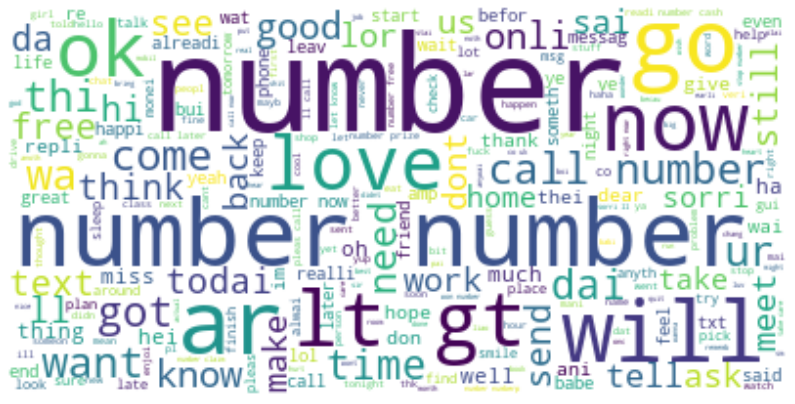

In [54]:
import matplotlib.pyplot as plt

fig = plt.figure()
fig.set_figwidth(14)     
fig.set_figheight(18)    

# Display wordcloud
plt.imshow(SMS_wc, interpolation='bilinear')
plt.axis('off')
plt.show()

#fig.savefig('SMS_wordcloud-spam+ham.png', dpi=fig.dpi)

#### Read 'vocabSMS_' to dataframe 'df' with columns 'idx', 'word'

In [1]:
import pandas as pd

path = '/resources/Spam-SVM/vocabSMS_.txt'
df = pd.read_csv(path, sep=' ', names=('idx', 'word'))
df.head(20)

,idx,word
0,1,number
1,2,u
2,3,call
3,4,s
4,5,ar
5,6,now
6,7,t
7,8,go
8,9,m
9,10,will


#### Assign total number of examples (5,574) to *N*; redefine *m* as number of words in vocab list (*m* = 2,000)

In [2]:
N = df1.shape[0]

m = df.shape[0]
print('Total number of words in vocab list, m = %d' % m)

Total number of words in vocab list, m = 2000


#### 1.4.2. Index 'spam_proc.txt', 'ham_proc.txt'
To facilitate feature extraction &mdash; e.g., by allowing int-int rather than str-str comparisons to the vocab list when constructing feature vectors from the examples (see <a href='#Features'>**Section 2**</a>) &mdash; replace each word in 'spam_proc' and 'ham_proc' with its index in 'vocabSMS_'. Write output to '**spam_proc_idx_**', '**ham_proc_idx_**'. In the latter, omitted words correspond to those in 'spam+ham_proc' that were omitted from the vocab list because they are either stopwords, or less frequent than the 2,000 most frequently occurring (non-stopword) words.

In [4]:
# Function matches each word in the passed line / example to its index 
# in the vocab list (if present), and returns the example as a list of 
# matched indices

def word_idx(ex):
    words = ex.split()  # (Preprocessed) words in current line / example
    
    lst = []

    # Iterate by word in 'words'
    for j in words:
        for k in range(0,m):    
            if ( j == df.iloc[k,1] ):
                lst.append(df.iloc[k,0])
    return lst

#### Write 'spam_proc_idx_'

In [ ]:
spam_proc_idx = []

f = open('spam_proc.txt', 'r')
contents = f.readlines()

for i in contents:
    spam_proc_idx.append(word_idx(i))

f.close()

In [35]:
len(spam_proc_idx)  # Agrees with number of examples / lines in 'spam_proc'

747

In [ ]:
f = open('spam_proc_idx_.txt', 'w')

for i in range(0,len(spam_proc_idx)):
    print(*spam_proc_idx[i], file = f)

f.close()

In [10]:
f = open('spam_proc_idx_.txt', 'r')
contents = f.readlines()

print('First 5 lines of \'spam_proc_idx_\':\n')

ctr = 1
for i in contents:
    if ctr < 6:
        print(i)
    ctr += 1
        
f.close()

First 5 lines of 'spam_proc_idx_':

17 385 1 642 736 115 1584 923 305 1585 245 187 1 27 1584 1 212 385 274 787 32 236 7 75 4 298 4 

643 87 1091 4 1 55 4 6 159 49 53 322 44 1383 16 291 787 29 1 1 

567 520 299 154 281 1 94 737 82 3 1 82 335 428 1 192 28 

48 1 202 2 1001 371 251 386 48 265 17 3 48 371 71 17 1 

1586 246 115 105 1 1 1 361 32 29 1 247 52 18 644 1 298 39 1234 1 682 



#### Write 'ham_proc_idx_'

In [6]:
ham_proc_idx = []

f = open('ham_proc.txt', 'r')
contents = f.readlines()

for i in contents:
    ham_proc_idx.append(word_idx(i))

f.close()

In [12]:
len(ham_proc_idx)  # Agrees with number of examples / lines in 'ham_proc' (4,827)

In [ ]:
f = open('ham_proc_idx_.txt', 'w')

for i in range(0,len(ham_proc_idx)):
    print(*ham_proc_idx[i], file = f)

f.close()

In [13]:
f = open('ham_proc_idx_.txt', 'r')
contents = f.readlines()

print('First 5 lines of \'ham_proc_idx_\':\n')

ctr = 1
for i in contents:
    if ctr < 6:
        print(i)
    ctr += 1
        
f.close()

First 5 lines of 'ham_proc_idx_':

8 308 618 531 28 1150 46 79 253 1151 102 1152 25 86 

16 272 559 381 2 1696 

2 184 58 316 2 75 103 58 

885 43 7 38 393 814 175 163 378 

99 468 292 59 512 



<a name='Features'></a>
## 2. Feature Extraction

<a name='Vectors'></a>
### 2.1. Write **X** and **y**
A matrix **X** of feature vectors (one vector per example), and a vector **y** of corresponding labels, were generated by comparing each example in 'spam_proc_idx_', 'ham_proc_idx_' to the vocabulary list. Specifically, for each example, each word (index) in the vocab list was compared to each word (index) in the example. If a word in the vocab list was found in the example, that word was assigned the value 1 in the example's feature vector. If the word was not found in the example, it was assigned the value 0 in the example's feature vector. Thus, for every example *i*, we obtained a feature vector **x**\\(_i\\) of length *m* = 2,000, containing a unique set of integer values 1 and 0 representing the content of the example.  

For all examples in 'spam_proc_idx_', *y* = 1, and for all examples in 'ham_proc_idx_', *y* = 0.

The resulting matrix **X** and corresponding vector **y** were written to 'SMS_X_' (<a href='#211'>**2.1.1**</a>) and 'SMS_y_' (<a href='#212'>**2.1.2**</a>), which facilitate restarting the analysis at this point (<a href='#213'>**2.1.3**</a>).

<a name='211'></a>
#### 2.1.1. Write 'SMS_X_'&ensp;(all examples)
Write matrix for spam (*y* = 1) examples and matrix for ham (*y* = 0) examples, then cat the two matrices as 'SMS_X_'.

#### Write spam feature matrix, **X1** 
Dimensions: (*n = number of examples*) x (*m = length of vectors = length of vocab list*)

In [14]:
m = 2000

# Length of 'spam_proc' and 'spam_proc_idx_' (number of spam examples)
n = 747

In [15]:
import numpy as np

X1 = np.zeros((n,m))

In [16]:
X1.shape

(747, 2000)

In [11]:
def vectors(ex,row):
    indices = ex.split()
    
    for k in range(0,m):
        for j in indices:
            j = int(j)
            if j == df.iloc[k,0]:
                X1[row,k] = 1

In [12]:
f = open('spam_proc_idx_.txt', 'r')

contents = f.readlines()
ctr = 0
for i in contents:
    vectors(i,ctr)
    ctr += 1

f.close()

In [14]:
ctr

747

In [15]:
X1[0,0:100] 

array([1., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [16]:
X1[746,0:100]

array([1., 1., 1., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0., 0.])

Write **X1** to 'spam_proc_X_'

In [16]:
f_X = open('spam_proc_X_.txt', 'w')
for i in range(0,n):
    for j in range(0,m):
        f_X.write('%d ' % X1[i,j])
    f_X.write('\n')
f_X.close()

#### Write ham feature matrix, **X0** 
Dimensions: (*n = number of examples*) x (*m = length of vectors = length of vocab list*)

In [7]:
m = 2000

# Length of 'ham_proc' and 'ham_proc_idx_' (number of ham examples)
n = 4827

In [8]:
X0 = np.zeros((n,m))

In [9]:
X0.shape

(4827, 2000)

In [20]:
def vectors(ex,row):
    indices = ex.split()
        
    for k in range(0,m):
        for j in indices:
            j = int(j)
            if j == df.iloc[k,0]:
                X0[row,k] = 1

In [21]:
f = open('ham_proc_idx_.txt', 'r')

contents = f.readlines()
ctr = 0
for i in contents:     
    vectors(i,ctr)   
    ctr += 1
f.close()    

In [23]:
ctr   

4827

In [24]:
X0[0,0:100]  

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [25]:
X0[4826,0:100]    

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Write **X0** to 'ham_proc_X_'

In [26]:
f_X = open('ham_proc_X_.txt', 'w')
for i in range(0,n):
    for j in range(0,m):
        f_X.write('%d ' % X0[i,j])
    f_X.write('\n')
f_X.close()

#### Concatenate **X1**, **X0** to combined feature matrix, **X** (dimensions *N* x *m*)

In [27]:
X = np.concatenate((X1,X0), axis = 0)

In [28]:
X.shape

(5574, 2000)

#### Write **X** to 'SMS_X_'

In [29]:
f = open('SMS_X_.txt', 'w')
for i in range(0,N):
    for j in range(0,m):
        f.write('%d ' % X[i,j])
    f.write('\n')
f.close()

<a name='212'></a>
#### 2.1.2. Write 'SMS_y_'&ensp;(all labels)
Write vector for spam (*y* = 1) labels and vector for ham (*y* = 0) labels, then cat the two vectors as 'SMS_y_'.

#### Write spam label vector, **y1** 
Dimensions: (*number of spam examples*) x (1)

In [30]:
y1 = np.ones((len(X1),1))

In [34]:
y1.shape

(747, 1)

#### Write ham label vector, **y0** 
Dimensions: (*number of ham examples*) x (1)

In [32]:
y0 = np.zeros((len(X0),1))

In [33]:
y0.shape

(4827, 1)

#### Concatenate **y1**, **y0** to combined label vector, **y** (dimensions *N* x 1)

In [35]:
y = np.concatenate((y1,y0), axis = 0)

In [36]:
y[746,0], y[747,0]

(1.0, 0.0)

#### Write **y** to 'SMS_y_'

In [36]:
f = open('SMS_y_.txt', 'w')
for i in range(0,N):
    f.write('%d\n' % y[i,0])
f.close()

<a name='213'></a>
#### 2.1.3. Restore **X**, **y** from files 'SMS_X_.txt', 'SMS_y_.txt'

In [1]:
import numpy as np

N = 5574     # Total number of examples
m = 2000     # Length of vocab list / feature vectors

In [2]:
X = np.zeros((N,m))

In [3]:
X.shape

(5574, 2000)

In [4]:
def vectors(ex,row):
    indices = ex.split()
    
    col = 0
    for j in indices:
        j = int(j)
        X[row,col] = j
        col += 1

In [5]:
f = open('SMS_X_.txt', 'r')

contents = f.readlines()
ctr = 0
for i in contents:
    vectors(i,ctr)
    ctr += 1
f.close()

In [6]:
X.shape

(5574, 2000)

In [7]:
X

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [22]:
y = np.zeros((N,1))  # y = np.zeros((N,)) avoids version 'fit' warning 

In [21]:
y.shape

(5574, 1)

In [11]:
y[746,0], y[747,0]

(0.0, 0.0)

In [23]:
f = open('SMS_y_.txt', 'r')

contents = f.readlines()
ctr = 0
for i in contents:
    y[ctr,0] = i
    ctr += 1
f.close()

In [11]:
y.shape

(5574, 1)

In [14]:
y[746,0], y[747,0]

(1.0, 0.0)

### 2.2. Split **X** and **y** into training and test sets
25% (1,394) of the 5,574 total examples were randomly selected to provide a test set for models trained on the remaining 4,180 examples. 

In [12]:
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=4)

In [15]:
X_test.shape, y_test.shape, X_train.shape, y_train.shape

((1394, 2000), (1394, 1), (4180, 2000), (4180, 1))

#### Write **X** and **y** train / test sets to files

In [25]:
f = open('SMS_X_-train.txt', 'w')
for i in range(0,4180):
    for j in range(0,2000):
        f.write('%d ' % X_train[i,j])
    f.write('\n')
f.close()

In [26]:
f = open('SMS_y_-train.txt', 'w')
for i in range(0,4180):
    f.write('%d\n' % y_train[i,0])
f.close()

In [27]:
f = open('SMS_X_-test.txt', 'w')
for i in range(0,1394):
    for j in range(0,2000):
        f.write('%d ' % X_test[i,j])
    f.write('\n')
f.close()

In [28]:
f = open('SMS_y_-test.txt', 'w')
for i in range(0,1394):
    f.write('%d\n' % y_test[i,0])
f.close()

<a name='Model'></a>
## 3. Modeling & Analysis

### 3.1. Train and test the SVM classifier
To model the training data, we used the support vector classification (SVC) class provided in the 'scikit learn' support vector machine (SVM) library. In part owing to their applicability to high-dimensional feature spaces, SVM algorithms are well-known to be an effective modeling choice for accurate, efficient spam classification. In the algorithm used here ('sklearn.svm.SVC'), we chose a linear kernel, and a value of 0.1 for the regularization parameter, *C*.  

In [2]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

#### Train the model 

In [26]:
from sklearn import svm

In [27]:
clf = svm.SVC(kernel='linear', C=0.1, gamma='auto')
clf.fit(X_train, y_train)

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [28]:
yhat = clf.predict(X_train)
yhat [0:10]

array([0., 0., 0., 0., 0., 0., 0., 1., 0., 0.])

#### Calculate the model's accuracy against the training set

In [29]:
from sklearn.metrics import jaccard_similarity_score

jaccard_similarity_score(y_train, yhat)

0.9921052631578947

#### Calculate **accuracy** against the test set

In [30]:
yhat = clf.predict(X_test)
yhat [0:10]

array([0., 0., 0., 1., 0., 1., 0., 0., 0., 0.])

In [31]:
jaccard_similarity_score(y_test, yhat)

0.9863701578192252

<span style='color:indigo'><font size='5'>**0.9863701578192252**</font></span>

#### Generate / display a **classification report** and **confusion matrix**

In [60]:
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [61]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Reds):    
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

              precision    recall  f1-score   support

         0.0       0.99      1.00      0.99      1208
         1.0       0.99      0.90      0.95       186

   micro avg       0.99      0.99      0.99      1394
   macro avg       0.99      0.95      0.97      1394
weighted avg       0.99      0.99      0.99      1394

Confusion matrix, without normalization
[[1207    1]
 [  18  168]]


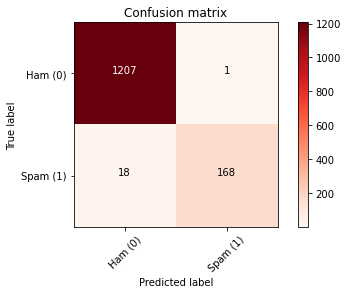

In [29]:
# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, yhat, labels=[0,1])    
np.set_printoptions(precision=2)

print (classification_report(y_test, yhat))

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Ham (0)','Spam (1)'],normalize= False,  title='Confusion matrix')

#### Calculate \\(F_1\text{,}\\) **precision**, and **recall** scores

In [32]:
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score

f1_score(y_test, yhat, average='weighted') 

0.9860914271008298

<span style='color:indigo'><font size='5'>**0.9860914271008298**</font></span>

In [65]:
precision_score(y_test, yhat, average='weighted')

0.9864771909629778

In [66]:
recall_score(y_test, yhat, average='weighted')

0.9863701578192252

### 3.2. Rank the SMS vocabulary words as predictors of spam
The fitted parameter (i.e., weight) values were sorted in descending order. The list of corresponding words in 'vocabSMS_' ranks the 2,000 most frequently-occurring words in the SMS dataset (omitting stopwords) from most to least predictive of spam.     

In [29]:
clf

SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [33]:
W = clf.coef_

In [34]:
W.shape

(1, 2000)

In [35]:
W

array([[ 0.64335591, -0.15852013,  0.46625571, ...,  0.        ,
         0.03094458,  0.04205147]])

In [36]:
np.amax(W)

0.7838872489745269

In [37]:
np.argmax(W)

51

In [38]:
W[0,51]     # Position 52 in 'vocabSMS_' = 'numberp'

0.7838872489745269

In [37]:
dfW = pd.DataFrame(W)

In [38]:
dfW

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.643356,-0.15852,0.466256,-0.051388,0.144724,0.237545,-0.029026,-0.082384,-0.129716,-0.04483,...,0.0,0.0,0.068554,0.1,0.1,0.1,0.1,0.0,0.030945,0.042051


In [39]:
Wsrt = -np.sort(-W)

In [43]:
Wsrt.shape

(1, 2000)

In [44]:
Wsrt

array([[ 0.78388725,  0.67175003,  0.64335591, ..., -0.28995467,
        -0.29453247, -0.29975577]])

In [45]:
dfWsrt = pd.DataFrame(Wsrt)

In [46]:
dfWsrt

,0,1,2,3,4,5,6,7,8,9,...,1990,1991,1992,1993,1994,1995,1996,1997,1998,1999
0,0.783887,0.67175,0.643356,0.621409,0.601879,0.585937,0.566945,0.558732,0.518414,0.501873,...,-0.226623,-0.241648,-0.250653,-0.250875,-0.260722,-0.263262,-0.26978,-0.289955,-0.294532,-0.299756


In [51]:
Wsrt_idx = np.zeros((W.shape[1],2))

In [52]:
Wsrt_idx.shape

(2000, 2)

In [53]:
Wsrt_idx = Wsrt_idx.astype('str')

In [56]:
ctr = 0
for i in range(0,Wsrt.shape[1]):
    for j in range(0,W.shape[1]):
        if ( dfW.iloc[0,j] == dfWsrt.iloc[0,i] ):
            Wsrt_idx[i,0] = df.iloc[j,1]
            Wsrt_idx[i,1] = W[0,j]
    ctr += 1

In [57]:
dfWsrt_idx = pd.DataFrame(Wsrt_idx)
dfWsrt_idx.head(15)

,0,1
0,numberp,0.7838872489745269
1,txt,0.6717500267527078
2,number,0.6433559062230254
3,rington,0.6214090134006139
4,httpaddr,0.6018788254615973
5,claim,0.5859367870689165
6,servic,0.5669446683127145
7,uk,0.5587318493752339
8,text,0.5184137737415964
9,repli,0.5018727107768512


Top 15 predictors of spam among the processed words in the SMS dataset.

<a name='Results'></a>
## 4. Results & Conclusion

The following table summarizes the analysis presented in **Section 3**.


|              | Training Set | Test Set |
|--------------|--------------|----------|
|   Accuracy   |     0.9921   |   0.9864 |
| F<sub>1</sub>|       -      |   0.9861 |
|   *P*        |       -      |   0.9865 |
|   *R*        |       -      |   0.9864 |

